## Search Analysis with Hyperopt - Trials

Hyperopt comes with a few plotting functions that help analyze the search. We will showcase those here, although in my opinion they are not great, and also, there is no documentation other than the source code.

We will use the trials class to store information about the search.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb

In [3]:
from hyperopt import hp, fmin, Trials
from hyperopt import rand, anneal, tpe
from hyperopt import STATUS_OK, STATUS_FAIL

In [4]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
y = y.map({0:1, 1:0})

X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
y.value_counts() /len(y)

target
0    0.627417
1    0.372583
Name: count, dtype: float64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((398, 30), (171, 30))

### Define the hyperparameter space

In [7]:
param_grid = {
    'n_estimators' : hp.quniform('n_estimatores', 200, 2500, 100),
    'max_depth' : hp.quniform('max_depth', 2, 10, 1),
    'learning_rate' : hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'booster' : hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
    'gamma' : hp.loguniform('gamma', np.log(0.01), np.log(10)),
    'subsample' : hp.uniform('subsample', 0.5, 0.9),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 0.99),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0.5, 0.99),
    'colsample_bynode' : hp.uniform('colsample_bynode', 0.5, 0.99),
    'reg_lambda' : hp.uniform('reg_lambda', 1, 20),

}

In [10]:
# This is the hyperparameter response space, the function we want to minimize
def objective(params):

    params_dict = {
        #import int, as it takes integers only
        'n_estimators' : int(params['n_estimators']),
        #import int, as it takes integers only
        'max_depth' : int(params['max_depth']),
        'learning_rate' : params['learning_rate'],
        'booster' : params['booster'],
        'gamma' : params['gamma'],
        'subsample' : params['subsample'],
        'colsample_bytree' : params['colsample_bytree'],
        'colsample_bylevel' : params['colsample_bylevel'],
        'colsample_bynode' : params['colsample_bynode'],
        'random_state' : 42,
    }

    #With ** we pass the items in the dictionary as parameters to the xgb
    gbm = xgb.XGBClassifier(**params_dict)

    #Train with cv
    cross_val_data = cross_val_score(
        gbm, X_train, y_train,
        scoring = 'accuracy', cv = 3, n_jobs=4,
    )

    #Data to be returned by the search, we can add as mch as we want
    loss= -cross_val_data.mean()
    loss_variance = cross_val_data.std()

    try:
        return{
            'loss' : loss,
            'loss_variance' : loss_variance,
            'status' : STATUS_OK
        }
    except Exception as e:
        return {
            'Exception' : str(e),
            'status' : STATUS_FAIL
        }
    

### Randomized Search

-> **fmin** : returns the best hyperparameters found during the search
-> **rand** : performs randomized search
-> **Trials** : captures the search information

In [11]:
#fmin performs the minimization
#rand suggest samples the parametrs at random
#$ i.e, performs the random search

trials = Trials()

random_search = fmin(
    fn = objective,
    space = param_grid, 
    max_evals = 50,
    rstate= np.random.default_rng(42),
    algo = rand.suggest,
    trials = trials,  
)

100%|██████████| 50/50 [20:01<00:00, 24.02s/trial, best loss: -0.9698298777246146]


In [12]:
random_search

{'booster': 1,
 'colsample_bylevel': 0.6903076828835399,
 'colsample_bynode': 0.7482568348986202,
 'colsample_bytree': 0.6366884320251598,
 'gamma': 0.0869526442133663,
 'learning_rate': 0.030562167330765756,
 'max_depth': 9.0,
 'n_estimatores': 2300.0,
 'reg_lambda': 5.228660228386823,
 'subsample': 0.8662214527772187}

In [13]:
trials.argmin

{'booster': 1,
 'colsample_bylevel': 0.6903076828835399,
 'colsample_bynode': 0.7482568348986202,
 'colsample_bytree': 0.6366884320251598,
 'gamma': 0.0869526442133663,
 'learning_rate': 0.030562167330765756,
 'max_depth': 9.0,
 'n_estimatores': 2300.0,
 'reg_lambda': 5.228660228386823,
 'subsample': 0.8662214527772187}

In [14]:
# The search hyperparameter combinations
pd.DataFrame(trials.vals).head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimatores,reg_lambda,subsample
0,0,0.737251,0.658760,0.850624,0.021948,0.343331,7.0,2200.0,12.782261,0.825462
1,0,0.667518,0.502689,0.933592,0.017256,0.134331,2.0,2200.0,12.556734,0.620169
2,2,0.826309,0.757590,0.936663,2.953222,0.139784,3.0,1600.0,2.399559,0.558785
3,0,0.623687,0.785930,0.600911,0.317872,0.014055,8.0,1600.0,5.032125,0.661511
4,0,0.832376,0.873171,0.746166,0.162446,0.047460,5.0,900.0,2.836248,0.701162


In [15]:
#The results
pd.DataFrame(trials.results).head()

,loss,loss_variance,status
0,-0.964760,0.021737,ok
1,-0.962273,0.016366,ok
2,-0.957242,0.019870,ok
3,-0.967305,0.012892,ok
4,-0.969811,0.016348,ok


In [16]:
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results.head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimatores,reg_lambda,subsample,loss,loss_variance,status
0,1,0.603563,0.684215,0.898185,0.393697,0.955986,5.0,1900.0,3.889106,0.772154,-0.374364,0.002229,ok
1,1,0.685851,0.914520,0.672244,0.111627,0.970090,7.0,300.0,15.656236,0.789319,-0.460223,0.119194,ok
2,1,0.577525,0.956901,0.801530,0.020734,0.518217,5.0,700.0,19.767007,0.850099,-0.460223,0.119194,ok
3,1,0.696808,0.546859,0.887333,0.084212,0.608329,3.0,900.0,13.437682,0.558489,-0.625636,0.002229,ok
4,1,0.707979,0.852354,0.538706,3.009610,0.487925,6.0,2200.0,12.143680,0.656224,-0.729171,0.148650,ok


### Plotting with hyperopt


In [17]:
from hyperopt import plotting as hpplot

avg best error: -0.9403518265360371


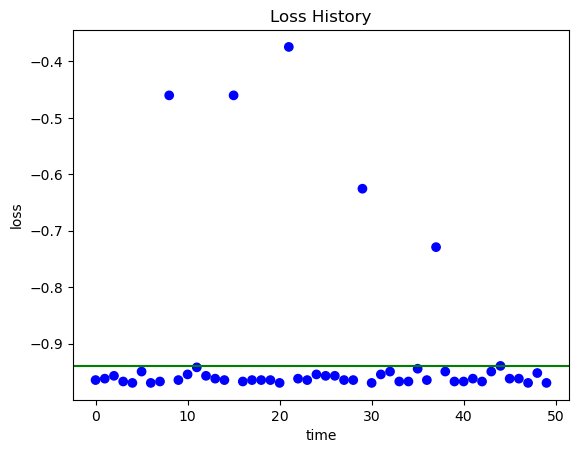

In [18]:
hpplot.main_plot_history(trials)

Showing Histogram of 50 jobs


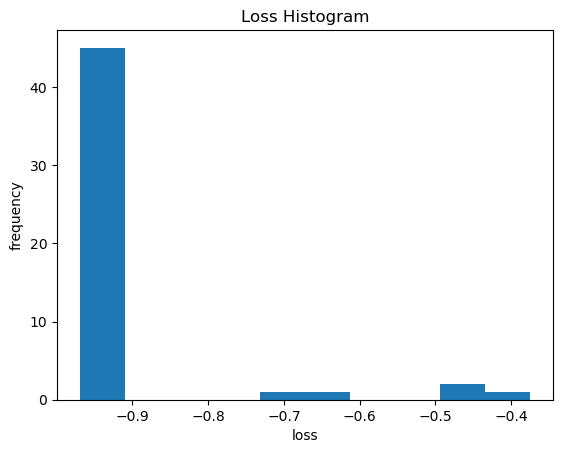

In [19]:
hpplot.main_plot_histogram(trials)

finite loss range -0.9698298777246146 -0.37436394015341384 -0.9698108908635223


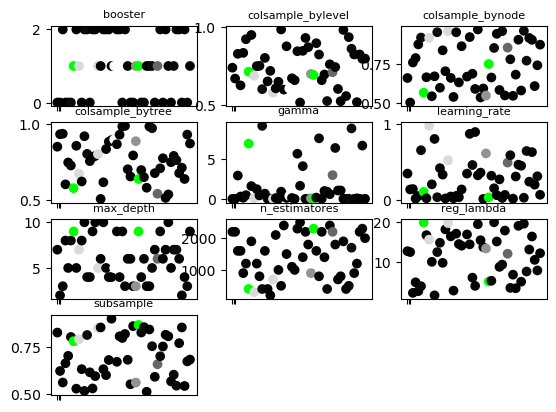

In [20]:
hpplot.main_plot_vars(
    trials,
    do_show=True,
    fontsize=8,
    colorize_best=True,
    columns=3,
    arrange_by_loss=False,
)

In [21]:
#Home made plots
results = pd.concat([
    pd.DataFrame(trials.vals),
    pd.DataFrame(trials.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

results.head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimatores,reg_lambda,subsample,loss,loss_variance,status,index
0,1,0.603563,0.684215,0.898185,0.393697,0.955986,5.0,1900.0,3.889106,0.772154,-0.374364,0.002229,ok,0
1,1,0.685851,0.914520,0.672244,0.111627,0.970090,7.0,300.0,15.656236,0.789319,-0.460223,0.119194,ok,1
2,1,0.577525,0.956901,0.801530,0.020734,0.518217,5.0,700.0,19.767007,0.850099,-0.460223,0.119194,ok,2
3,1,0.696808,0.546859,0.887333,0.084212,0.608329,3.0,900.0,13.437682,0.558489,-0.625636,0.002229,ok,3
4,1,0.707979,0.852354,0.538706,3.009610,0.487925,6.0,2200.0,12.143680,0.656224,-0.729171,0.148650,ok,4


Text(0.5, 0, 'Hyperparam combination')

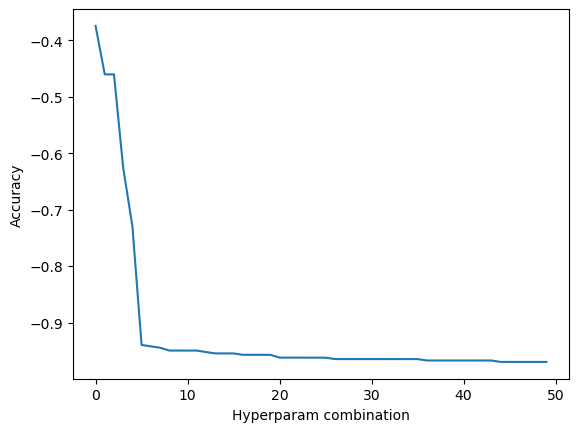

In [22]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

Text(0.5, 1.0, 'Random Search')

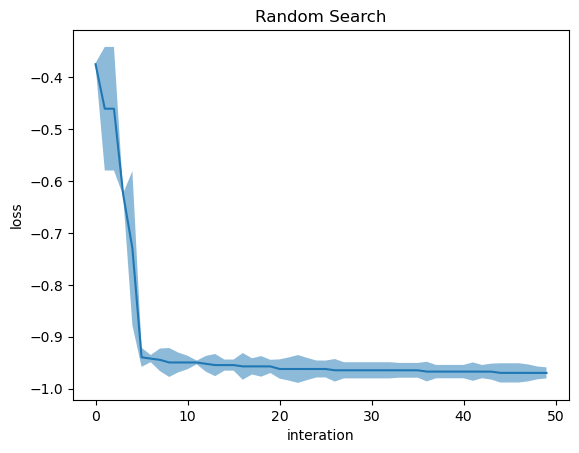

In [23]:
ax = sns.lineplot(x=r'index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('Random Search')

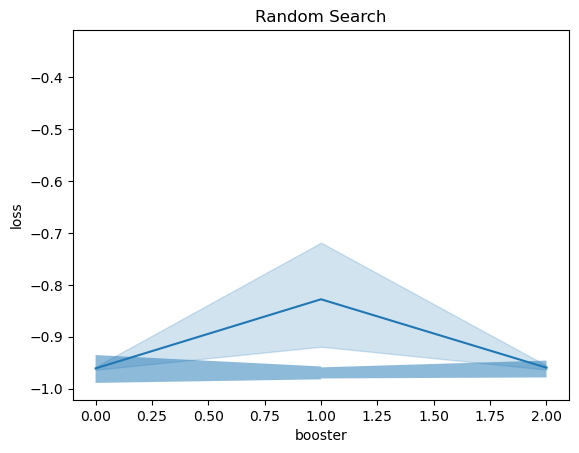

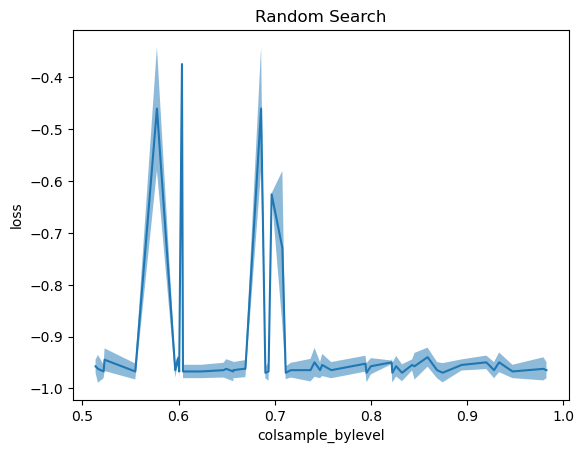

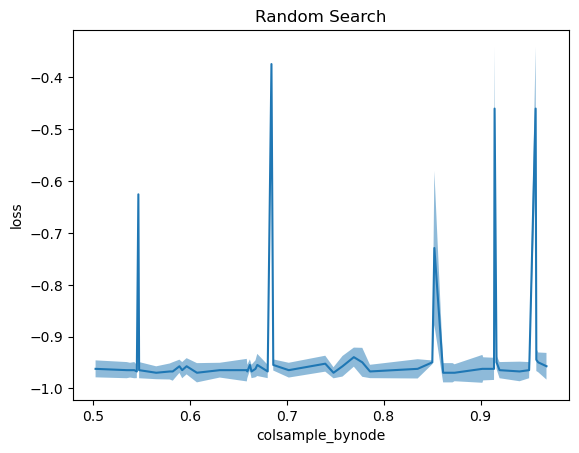

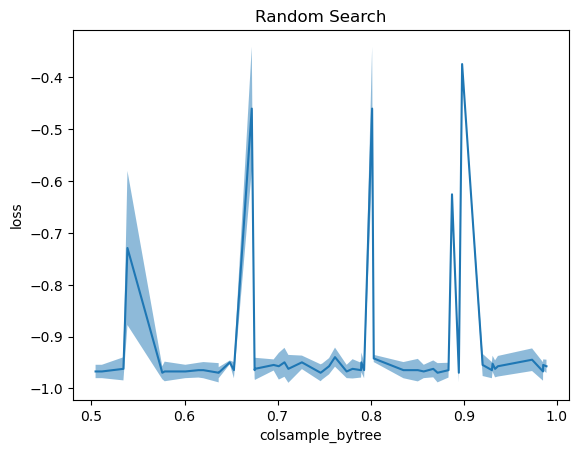

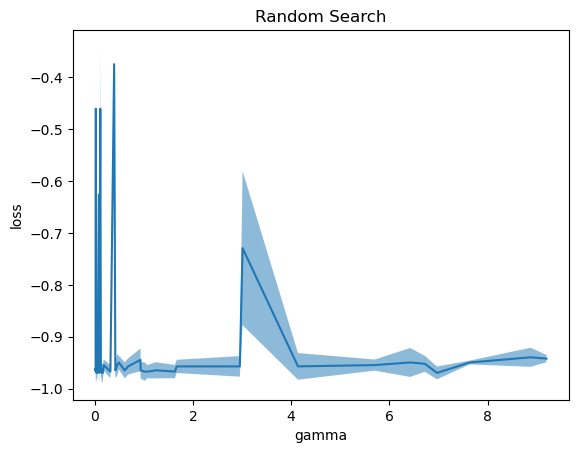

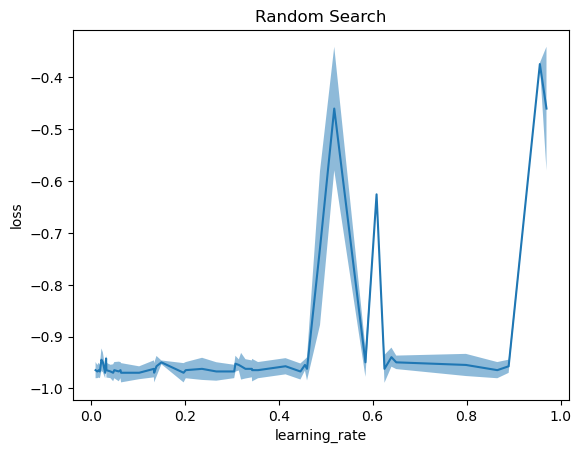

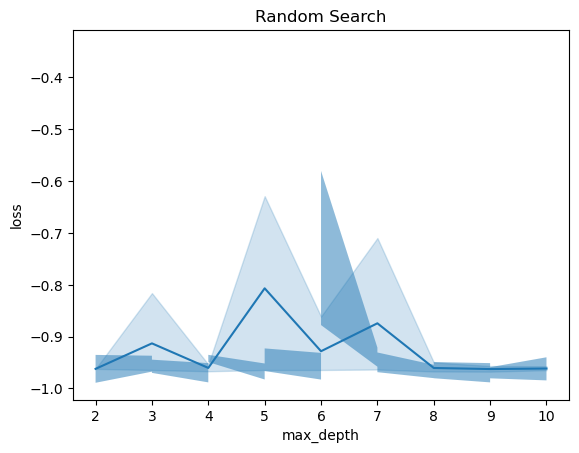

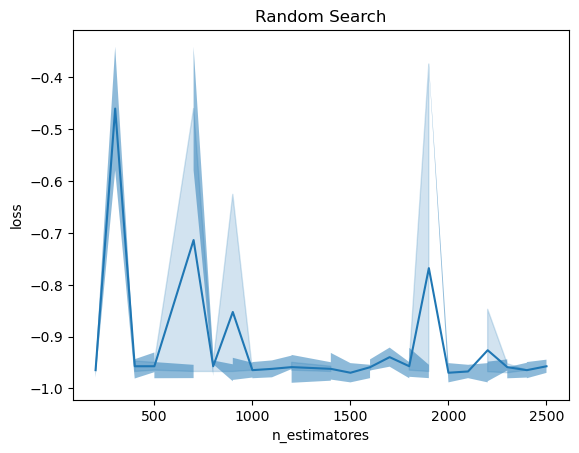

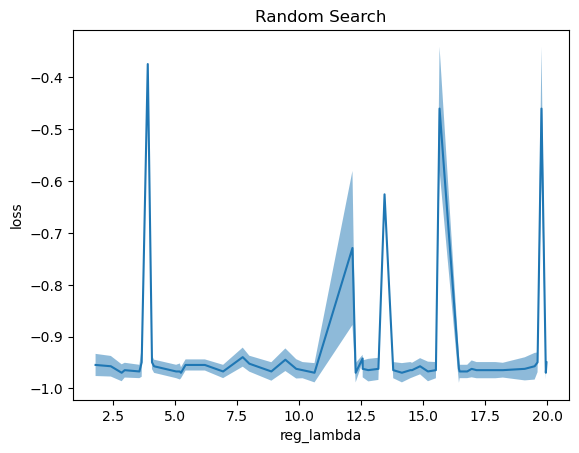

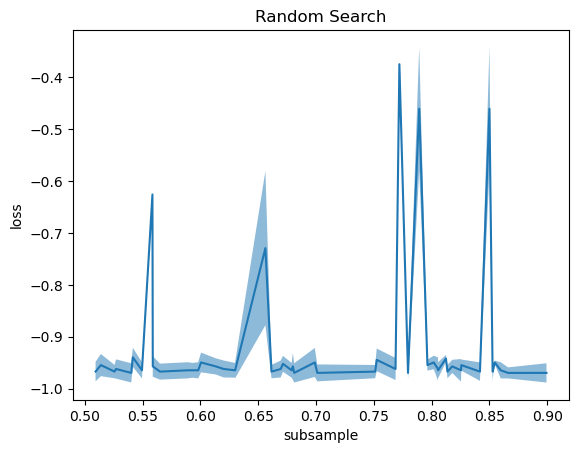

In [24]:
for var in results.columns[:-4]:
    
    tmp = results.sort_values(by=var, ascending=True)
    
    ax = sns.lineplot(x=var, y='loss', data=tmp)
    ax.fill_between(
        tmp[var],
        y1=tmp["loss"] - tmp["loss_variance"],
        y2=tmp["loss"] + tmp["loss_variance"],
        alpha=.5,
    )
    plt.xlabel(var)
    plt.title('Random Search')
    plt.show()

## TPE

**tpe** : performs TPE search for hyperparameters


In [25]:
trials_tpe = Trials()

tpe_search = fmin(
    fn=objective,
    space=param_grid,
    max_evals=50,
    rstate=np.random.default_rng(42),
    algo=tpe.suggest,  # tpe
    trials=trials_tpe
)

tpe_search

100%|██████████| 50/50 [10:49<00:00, 13.00s/trial, best loss: -0.9748234221918431]


{'booster': 1,
 'colsample_bylevel': 0.8965945841895235,
 'colsample_bynode': 0.8961102990804746,
 'colsample_bytree': 0.5675625816422436,
 'gamma': 0.010730875083044622,
 'learning_rate': 0.19815365141301963,
 'max_depth': 6.0,
 'n_estimatores': 600.0,
 'reg_lambda': 6.703876160405114,
 'subsample': 0.8478882918857902}

## Plotting with hyperopt

avg best error: -0.9630842447026657


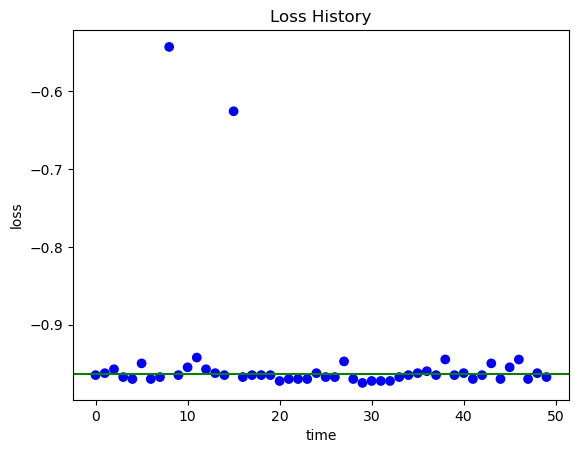

In [26]:
hpplot.main_plot_history(trials_tpe)

Showing Histogram of 50 jobs


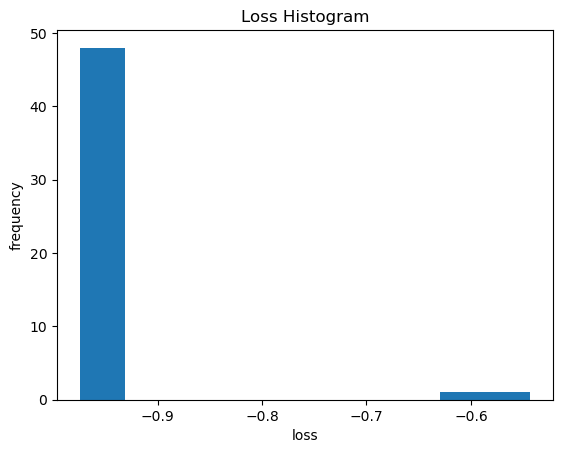

In [27]:
hpplot.main_plot_histogram(trials_tpe)

finite loss range -0.9748234221918431 -0.5429292929292929 -0.9723171565276828


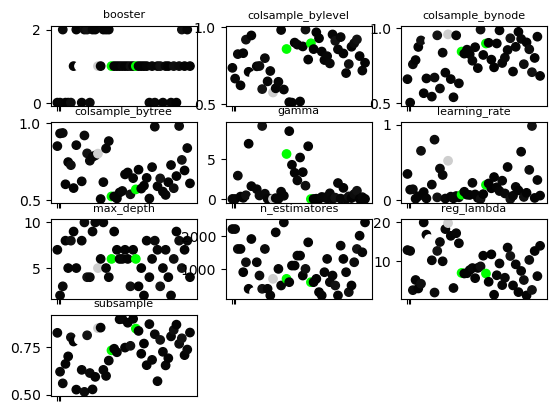

In [28]:
hpplot.main_plot_vars(
    trials_tpe,
    do_show=True,
    fontsize=8,
    colorize_best=True,
    columns=3,
    arrange_by_loss=False,
)

## Home made plots

In [29]:
results = pd.concat([
    pd.DataFrame(trials_tpe.vals),
    pd.DataFrame(trials_tpe.results)],
    axis=1,
).sort_values(by='loss', ascending=False).reset_index(drop=True)

results['index'] = results.index

results.head()

,booster,colsample_bylevel,colsample_bynode,colsample_bytree,gamma,learning_rate,max_depth,n_estimatores,reg_lambda,subsample,loss,loss_variance,status,index
0,1,0.685851,0.914520,0.672244,0.111627,0.970090,7.0,300.0,15.656236,0.789319,-0.542929,0.118095,ok,0
1,1,0.577525,0.956901,0.801530,0.020734,0.518217,5.0,700.0,19.767007,0.850099,-0.625636,0.002229,ok,1
2,2,0.599537,0.950542,0.803276,9.198977,0.032467,4.0,400.0,12.554895,0.812435,-0.942223,0.006997,ok,2
3,1,0.912110,0.931278,0.639486,0.185339,0.010471,3.0,500.0,11.244731,0.788016,-0.944653,0.025044,ok,3
4,2,0.921322,0.705136,0.760400,1.050264,0.980198,5.0,1600.0,2.457554,0.796597,-0.944710,0.012841,ok,4


Text(0.5, 0, 'Hyperparam combination')

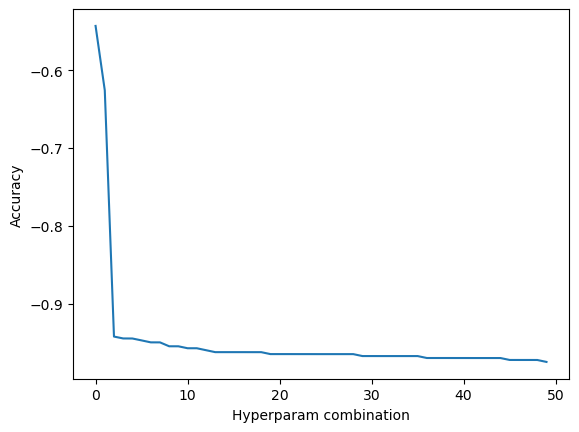

In [30]:
results['loss'].plot()
plt.ylabel('Accuracy')
plt.xlabel('Hyperparam combination')

Text(0.5, 1.0, 'Random Search')

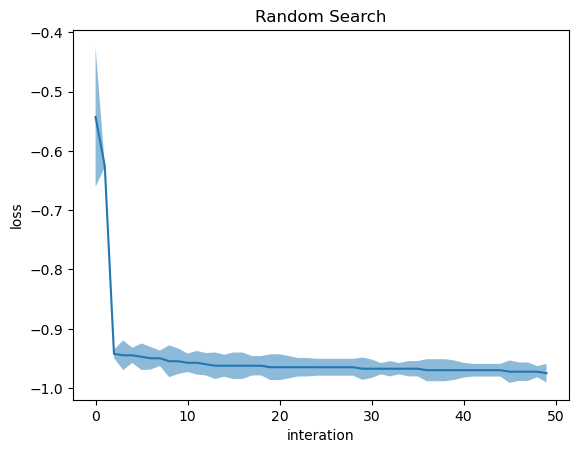

In [31]:
ax = sns.lineplot(x=r'index', y='loss', data=results)
ax.fill_between(
    results["index"],
    y1=results["loss"] - results["loss_variance"],
    y2=results["loss"] + results["loss_variance"],
    alpha=.5,
)
plt.xlabel('interation')
plt.title('Random Search')

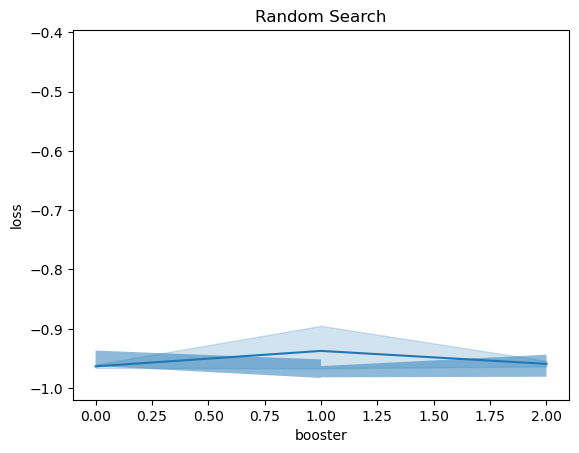

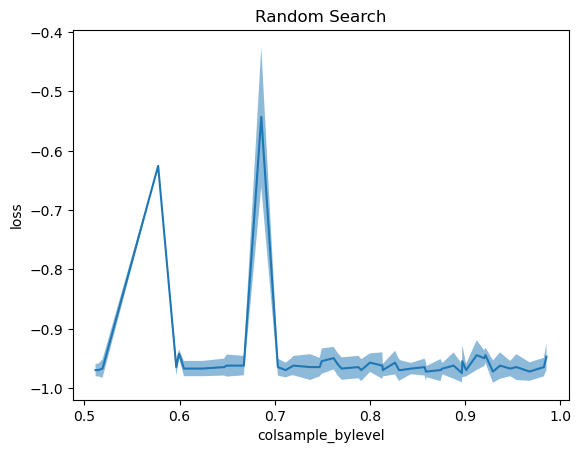

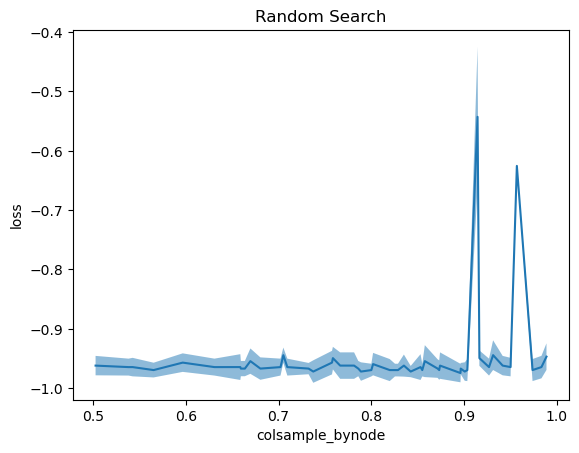

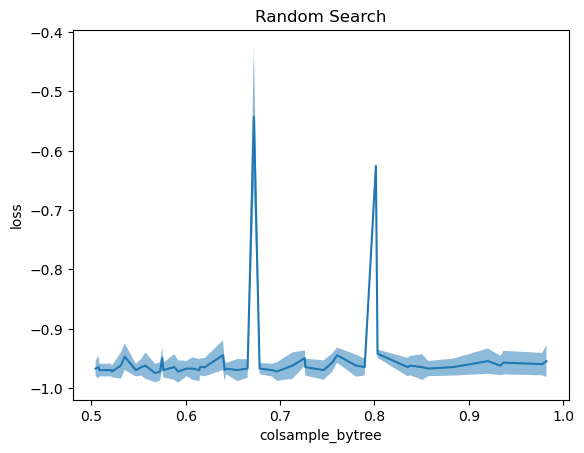

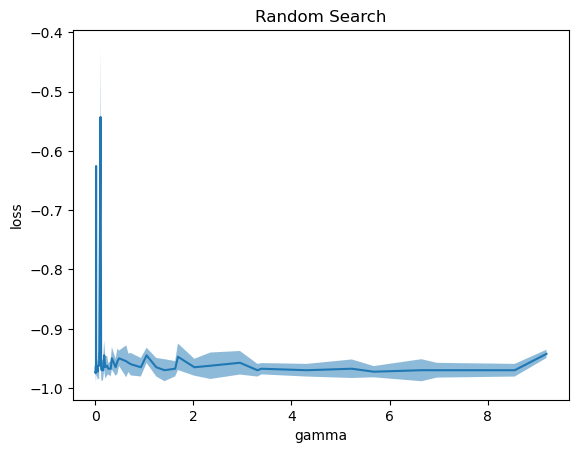

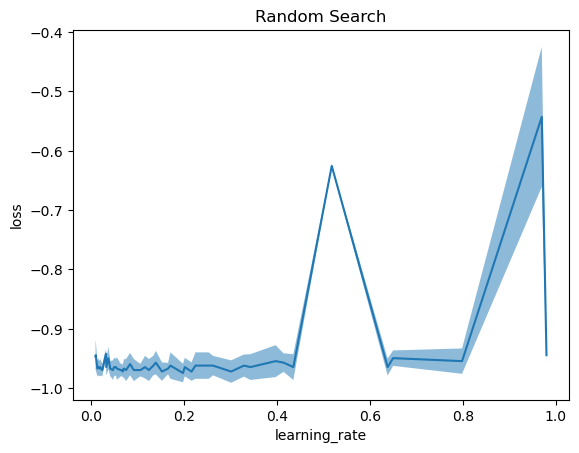

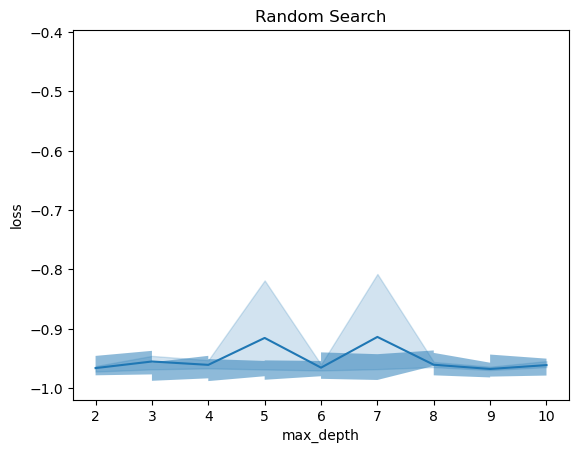

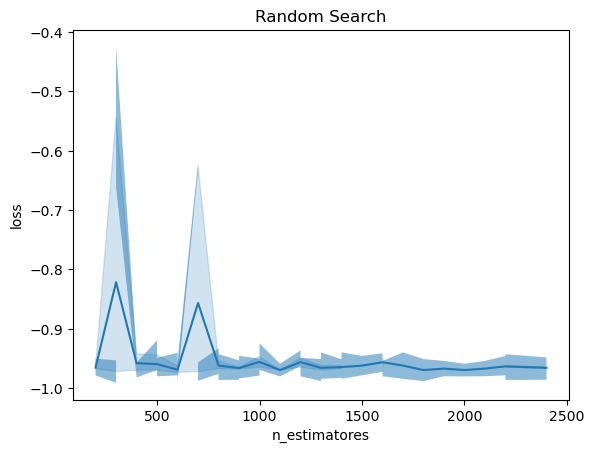

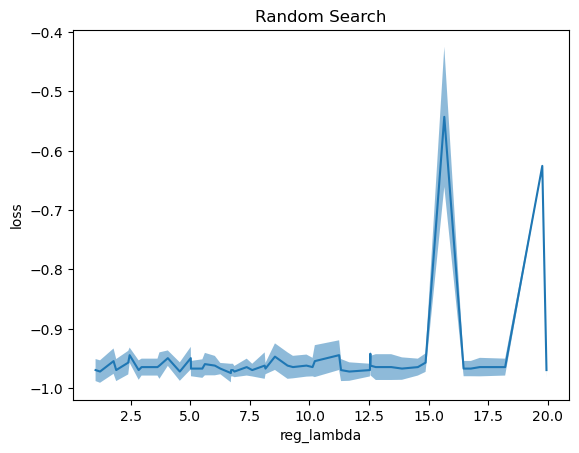

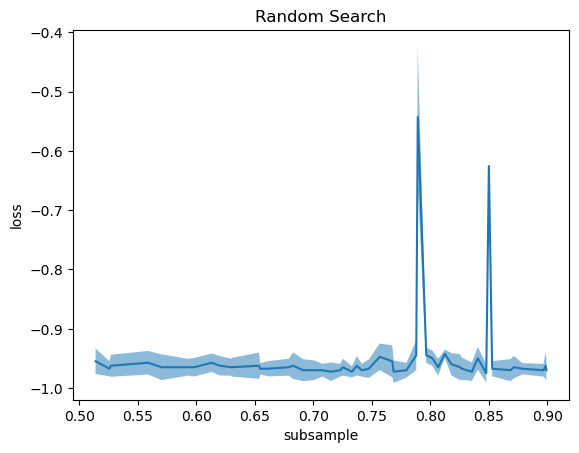

In [32]:
for var in results.columns[:-4]:
    
    tmp = results.sort_values(by=var, ascending=True)
    
    ax = sns.lineplot(x=var, y='loss', data=tmp)
    ax.fill_between(
        tmp[var],
        y1=tmp["loss"] - tmp["loss_variance"],
        y2=tmp["loss"] + tmp["loss_variance"],
        alpha=.5,
    )
    plt.xlabel(var)
    plt.title('Random Search')
    plt.show()

In [33]:
results.columns[:-2]

Index(['booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree',
       'gamma', 'learning_rate', 'max_depth', 'n_estimatores', 'reg_lambda',
       'subsample', 'loss', 'loss_variance'],
      dtype='object')

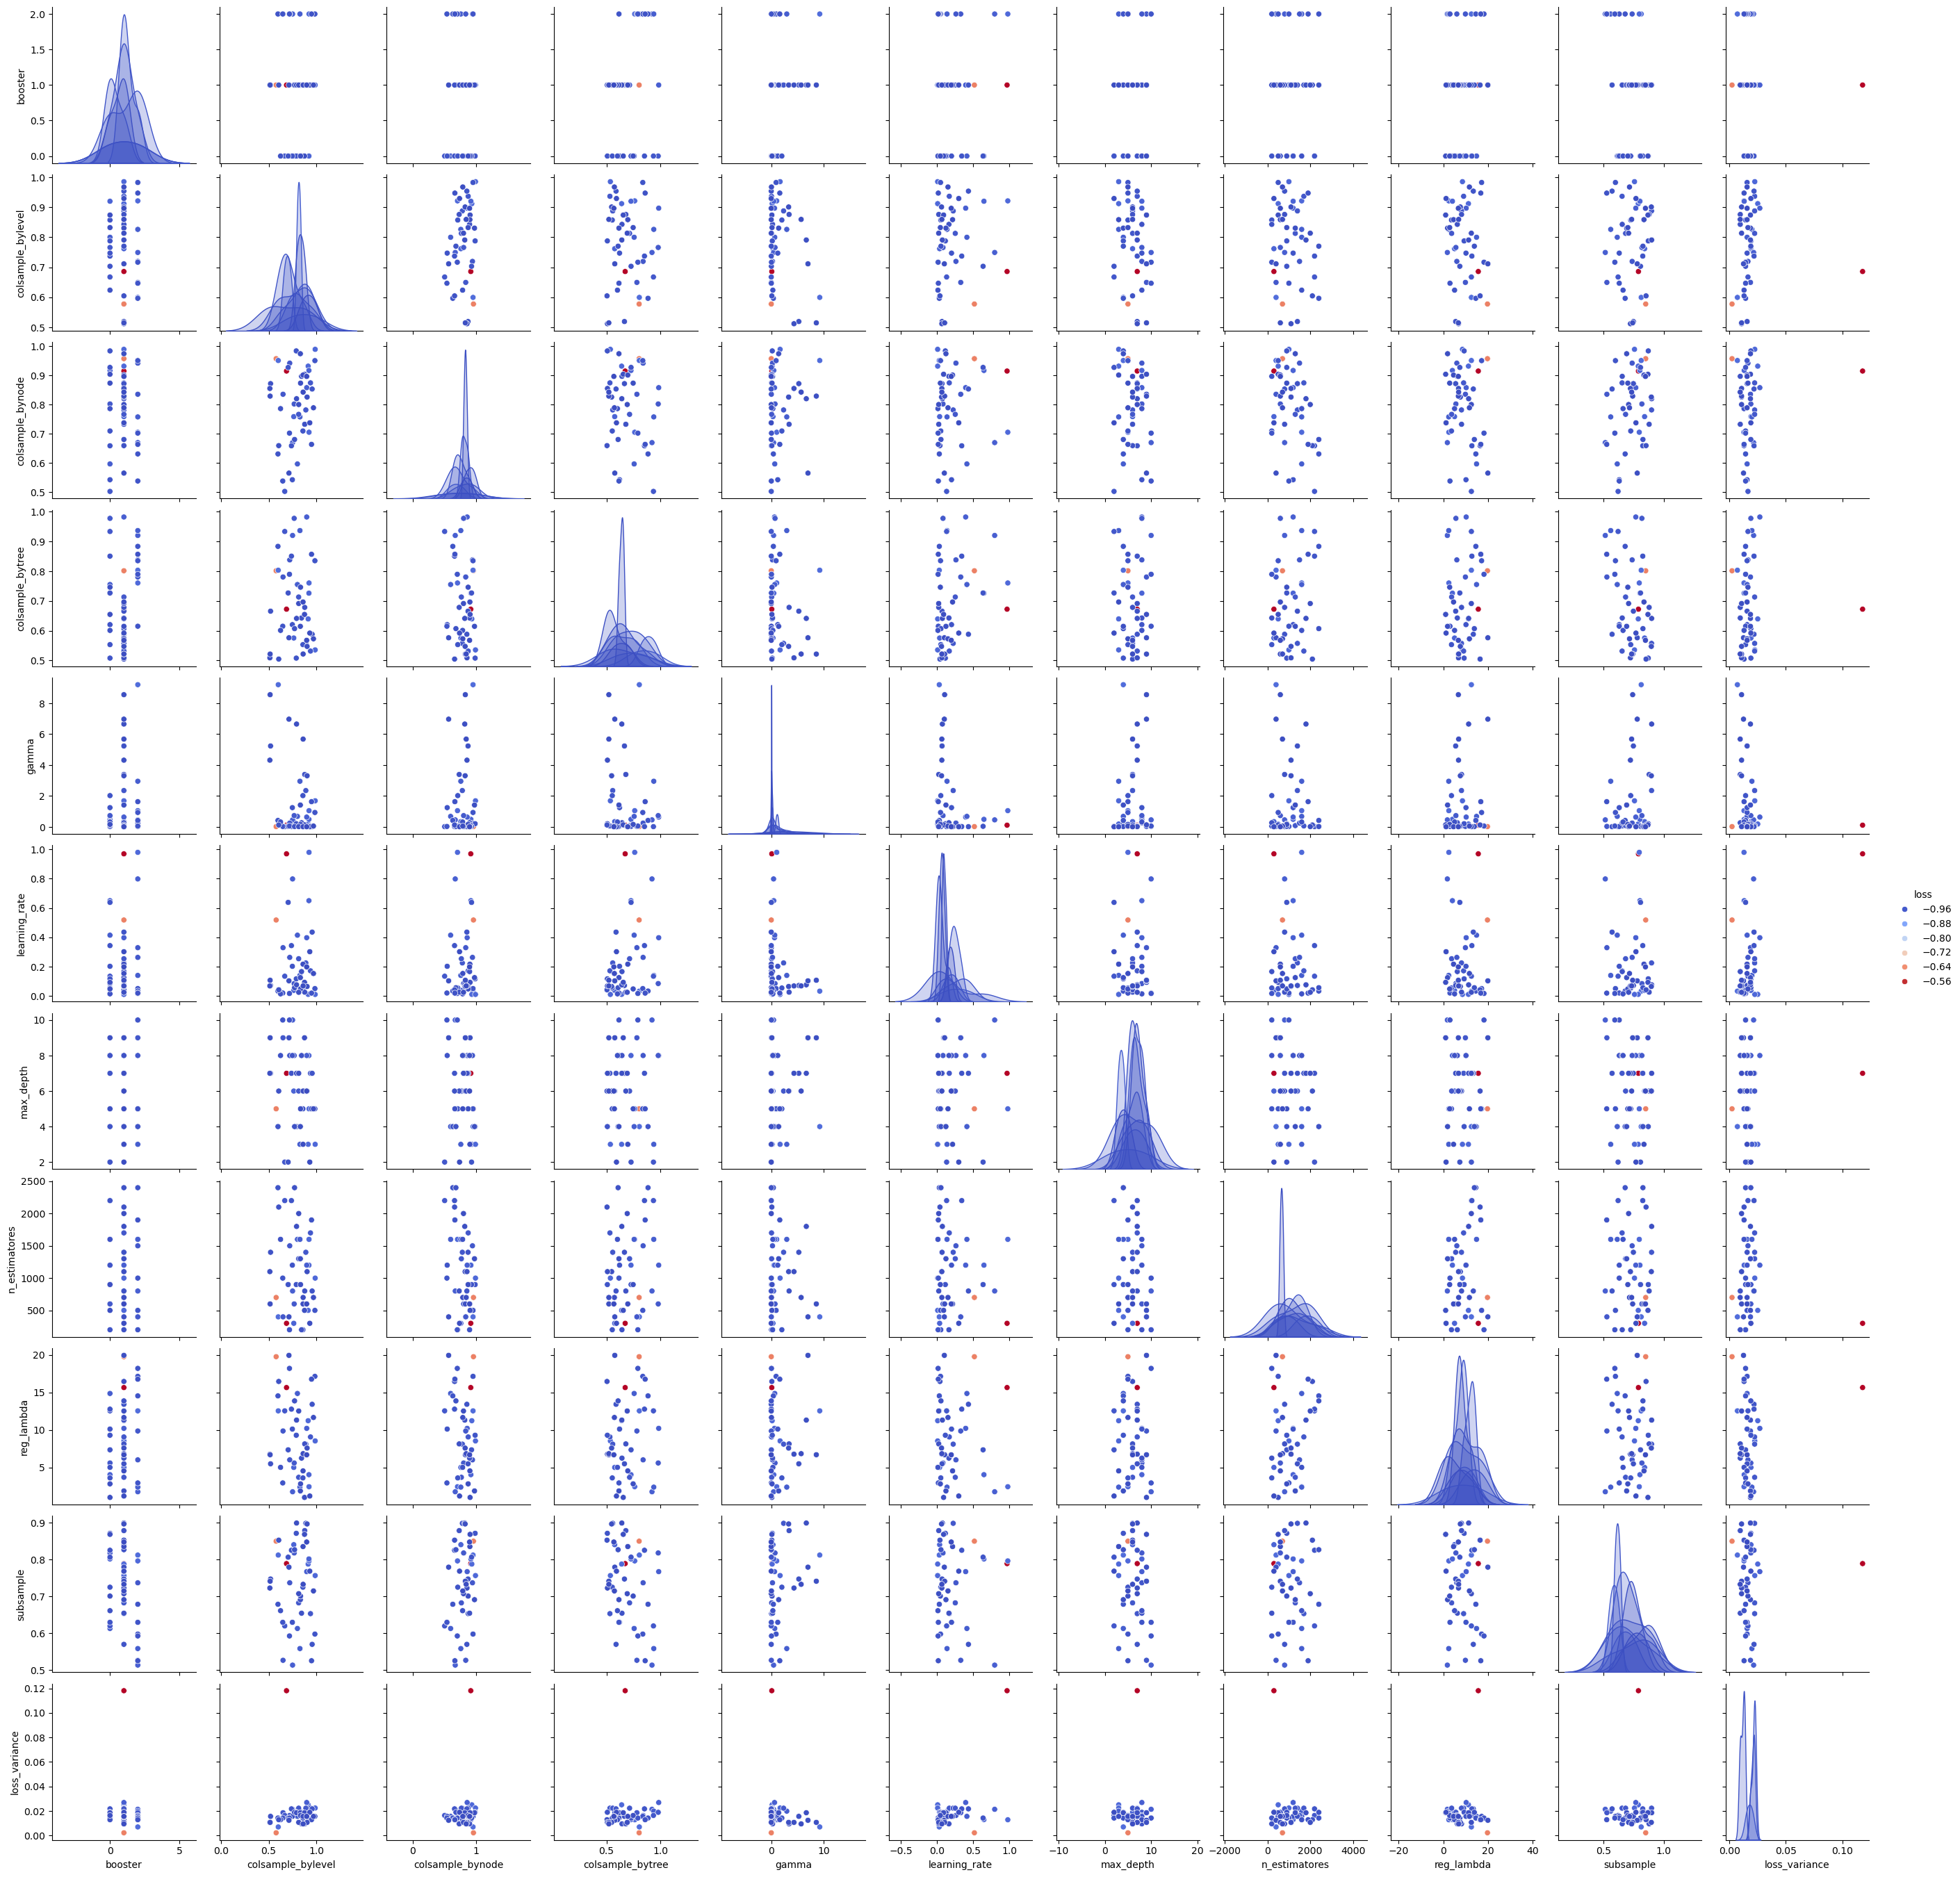

In [34]:
sns.pairplot(results[results.columns[:-2]], hue ="loss", palette ='coolwarm')
plt.show()